In [1]:
import rasterio
import numpy as np
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
from collections import namedtuple
import seaborn as sns
import matplotlib

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import csv

import fiona
import time
from shapely.geometry import mapping, shape
from shapely.geometry import box as shBox
from rasterio import windows as win
from statsmodels.formula.api import ols
import rasterio.plot

# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn import preprocessing
# from sklearn import linear_model
# from sklearn import metrics


import io
from scipy import misc
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [2]:
lc_Address=r'Rasters\EU_LC_100.img'
tc_Address=r'Rasters\tc.img'
st_address=r'Rasters\st.img'
at_address=r'Rasters\airTemp.img'
eaa_raster_address=r'Rasters\EAA.img'
bldgSum_address = r'Rasters\bldgSum.tif'
eaa_vector_address=r'Vectors\RomeUrbanArea.shp'
dem_address= r'Rasters\dem.img'

In [3]:
def findWindow (shapeBound,mainRasterBnd,mainRasterCellSize):
    startRow = int((mainRasterBnd[3] - shapeBound[3])/mainRasterCellSize)
    endRow   = int((shapeBound[3] - shapeBound[1])/mainRasterCellSize)+1+startRow
    startCol = int((shapeBound[0] - mainRasterBnd[0])/mainRasterCellSize)
    endCol   = int((shapeBound[2] - shapeBound[0])/mainRasterCellSize)+1+startCol
    return (startRow,endRow,startCol,endCol)

In [4]:
with rasterio.open(tc_Address) as rst_tc:
            kwds = rst_tc.meta.copy()
            mainRasterBnd=rst_tc.bounds
            cellSize= kwds['transform'][0]

In [5]:
# name field from the eaa vector
nameField='URAU_NAME'
idField='EAA_ID'
countryCode='CNTR_CODE'
kbtuField='KBTU'

In [6]:
for pol in fiona.open(eaa_vector_address):
    #for pol in fiona.open(ecoAcAreasShapefile):
    eaa_name=(pol['properties'][nameField])
    eaa_country=(pol['properties'])[countryCode]
    eaa_id=(pol['properties'][idField])
    # kbtu per sq feet for residential use per year
    kbtu=(pol['properties'][kbtuField])
#     poly_Ycoor=(pol['properties']['Y_coor'])
    poly=(shape(pol['geometry']))
    #msaPoly=[shape(pol['geometry']) for pol in fiona.open(masShapeAddress)]

    with rasterio.open(tc_Address) as rst_tc:
        kwds = rst_tc.meta.copy()
        mainRasterBnd=rst_tc.bounds
        cellSize= kwds['transform'][0]

    polyBound = poly.bounds

    # create a window parameter tuple.   
    winProcessing=findWindow(polyBound,mainRasterBnd,cellSize)
    #(row_start, row_stop), (col_start, col_stop)
    window_use=((winProcessing[0],winProcessing[1]),(winProcessing[2],winProcessing[3]))

    # set the cells that do not have the city id as np.nan. This way we are getting cells insdie the boundary only.
    with rasterio.open(eaa_raster_address) as src:
        eaaAr=src.read(1, window=window_use)
        eaaNoData = (src.meta.copy())['nodata']
        arrayShapes=eaaAr.shape
        eaaAr=eaaAr.flatten()
        
    with rasterio.open(tc_Address) as rst_tc:
        tc_ar=rst_tc.read(1, window=window_use)
        tcNoData = (rst_tc.meta.copy())['nodata']
        tc_ar=tc_ar.astype('float')
        #nlcd_tc_win_ar[eaaAr!=eaa_id]=np.nan
        tc_ar=tc_ar.flatten()
        kwds = rst_tc.meta.copy()
        #print ('got the nlcd-tc layer')

    with rasterio.open(lc_Address) as src:
        lc_ar=src.read(1, window=window_use)
        lcNoData = (src.meta.copy())['nodata']
        lc_ar=lc_ar.astype('float')
        #nlcd_lc[eaaAr!=eaa_id]=np.nan
        lc_ar=lc_ar.flatten()
        #print('got the nlcd-lc layer')

    with rasterio.open(st_address) as src:
        st=src.read(1, window=window_use)
        stNoData = (src.meta.copy())['nodata']
        st=st.astype('float')
        st=st.flatten()
        
    with rasterio.open(at_address) as src:
        at=src.read(1, window=window_use)
        atNoData = (src.meta.copy())['nodata']
        at=at.astype('float')
        at=at.flatten()
        
    with rasterio.open(dem_address) as src:
        dem=src.read(1, window=window_use)
        demNoData = (src.meta.copy())['nodata']
        dem=dem.astype('float')
        dem=dem.flatten()
    
    with rasterio.open(bldgSum_address) as src:
        bldgSum = src.read(1,window=window_use)
        bldgNodata = (src.meta.copy())['nodata']
        bldgSum = bldgSum.astype('float')
        bldgSum = bldgSum.flatten()
        
    allArrays=np.dstack((tc_ar,lc_ar,st,at,eaaAr,bldgSum,dem))
    allArrays=allArrays[0,:,:]

    df=pd.DataFrame(allArrays,columns=['tc','lc','st','at','eaaAr','bldgSum','elevation'])

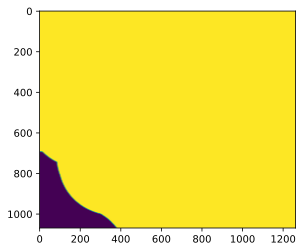

In [7]:
 with rasterio.open(dem_address) as src:
        dem = src.read(1,window=window_use)
        plt.imshow(dem)

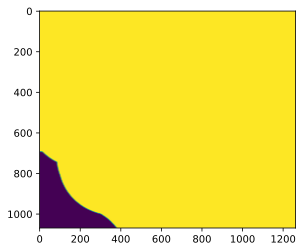

In [8]:
ar_test = np.array(df.elevation)
plt.imshow(ar_test.reshape(kwds['height'],kwds['width']))

In [9]:
st=df['st'].replace(stNoData, np.NaN)
at=df['at'].replace(atNoData, np.NaN)
lc=df['lc'].replace(lcNoData, np.NaN)
tc=df['tc'].replace(tcNoData, np.NaN)
eaaAr=df['eaaAr'].replace(eaaNoData, np.NaN)
bldgSum=df['bldgSum'].replace(bldgNodata, np.NaN)
elevation=df['elevation'].replace(demNoData, np.NaN)
st=st.replace(0,np.nan)
at=at.replace(0,np.nan)

In [10]:
list_of_series=[st,at,lc,tc,eaaAr,bldgSum,elevation]
df = pd.DataFrame(list_of_series)
df=df.transpose()
df.head()

st      at     lc    tc  eaaAr  bldgSum  elevation
0  3726.0  2986.0  311.0  63.0    NaN      0.0      175.0
1  3741.0  2986.0  311.0  74.0    NaN      0.0      180.0
2  3741.0  2986.0  311.0  74.0    NaN      0.0      181.0
3  3754.0  2985.0  311.0  74.0    NaN      0.0      180.0
4  3796.0  2985.0  311.0  69.0    NaN      0.0      180.0

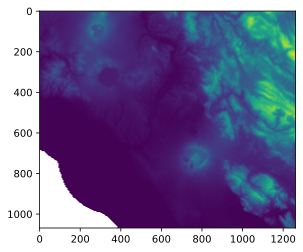

In [11]:
ar_test = np.array(df.elevation)
plt.imshow(ar_test.reshape(kwds['height'],kwds['width']))

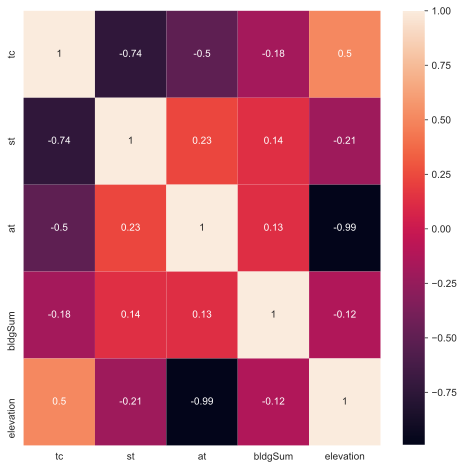

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
sns.heatmap(((df[['tc','st','at','bldgSum','elevation']]).corr()), annot=True)

In [13]:
df['st']=df['st']/100;
df['at']=df['at']/100;
df['bldgSum']=df['bldgSum']/100;

In [14]:
df.elevation.mean(skipna=True)

329.8376210288914

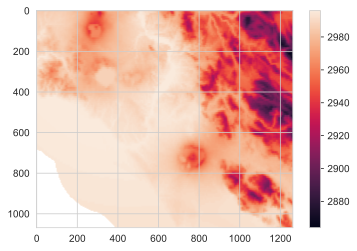

In [15]:
ar_test = np.array(at)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

In [16]:
features_airModel = ['tc']
depVar_airModel = df['at']
indepVar_airModel = sm.add_constant(df[features_airModel],has_constant='add')
# Fit and summarize OLS model
airModel = sm.OLS(depVar_airModel, indepVar_airModel,missing='drop')
results_airModel = airModel.fit()
print(results_airModel.summary())
## for prediction the following code will be used:
predict_airModel = results_airModel.get_prediction(indepVar_airModel)
predict_airModel = predict_airModel.summary_frame(alpha=0.05)

                            OLS Regression Results                            
Dep. Variable:                     at   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                 3.686e+05
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        18:07:58   Log-Likelihood:             1.1577e+05
No. Observations:             1085966   AIC:                        -2.315e+05
Df Residuals:                 1085964   BIC:                        -2.315e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.8226      0.000   1.03e+05      0.0

                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                 1.270e+06
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        18:09:54   Log-Likelihood:            -2.7180e+06
No. Observations:             1050440   AIC:                         5.436e+06
Df Residuals:                 1050438   BIC:                         5.436e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.2951      0.004   9929.162      0.0

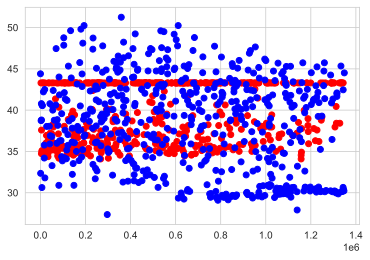

43.29505348749299

In [18]:
df['tc0']=0
features_st_model = ['tc']
depVar_st_model = df['st']
indepVar_st_model = sm.add_constant(df[features_st_model],has_constant='add')
st_model = sm.OLS(depVar_st_model, indepVar_st_model,missing='drop')
results_st_model = st_model.fit()
print(results_st_model.summary())
# now lets record the estimated ST
predict_st = results_st_model.get_prediction(indepVar_st_model)
predict_st = predict_st.summary_frame(alpha=0.05)
df['estimated_st'] = predict_st['mean']

# now let's see what whould be ST wit TC0
features_st_model_tc0 = ['tc0']
indepVar_st_model_tc0 = sm.add_constant(df[features_st_model_tc0],has_constant='add')
predict_st_tc0 = results_st_model.get_prediction(indepVar_st_model_tc0)
predict_st_tc0 = predict_st_tc0.summary_frame(alpha=0.05)
# create a col that shows the estiamted st when tc is 0
df['estimated_st_tc0'] = predict_st_tc0['mean']

#df.head()

predict_st_tc0

#residuals=predict_st['mean'] - df['st']

plt.plot(df['estimated_st'].sample(600),marker='o',color='red',linestyle='None')
plt.plot(df['st'].sample(600),marker='o',color='blue',linestyle='None')
plt.show()
df.head()

df.estimated_st.max()

#estimated st is a bit weird, despite the model fit is good, it seems like the model can't predict st over a value of 43.29 , with a lot of estimates densifying there

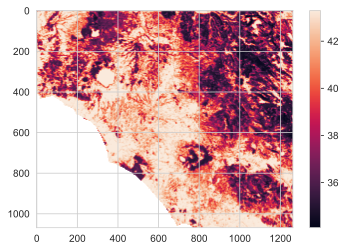

In [20]:
ar_test = np.array(df.estimated_st)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

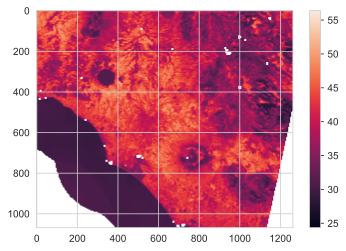

In [29]:
ar_test = np.array(df.st)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

In [23]:
# now let's build a model that uses st as the independent variable and estimates air temperature
features_at_model = ['st']
depVar_air_model = df['at']
indepVar_air_model = sm.add_constant(df[features_at_model],has_constant='add')
at_model = sm.OLS(depVar_air_model,indepVar_air_model,missing='drop')
results_at_model = at_model.fit()
print(results_at_model.summary())
# now let's estiamte air temperature with this model
predict_at = results_at_model.get_prediction(indepVar_air_model)
predict_at = predict_at.summary_frame(alpha=0.05)
df['estimated_air'] = predict_at['mean']

# now let's estiamte air temperature from esitmated_st_tc0
features_at_model_tc0 = ['estimated_st_tc0']
indepVar_air_model_tc0 = sm.add_constant(df[features_at_model_tc0],has_constant='add')

predict_air_tc0 = results_st_model.get_prediction(indepVar_air_model_tc0)
predict_air_tc0 = predict_air_tc0.summary_frame(alpha=0.05)
# create a col that shows the estiamted st when tc is 0
df['estimated_at_tc0'] = predict_air_tc0['mean']

# now let's calculate cooling
df['cooling'] = df['estimated_at_tc0']-df['estimated_air']

                            OLS Regression Results                            
Dep. Variable:                     at   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                 7.018e+04
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        18:16:05   Log-Likelihood:                 353.27
No. Observations:             1250312   AIC:                            -702.5
Df Residuals:                 1250310   BIC:                            -678.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.3523      0.001   1.99e+04      0.0

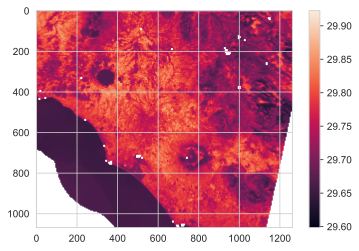

In [24]:
ar_test = np.array(df.estimated_air)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

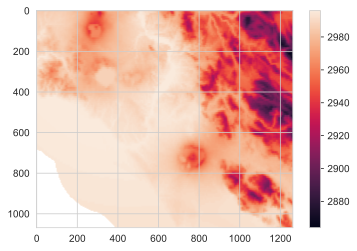

In [25]:
ar_test = np.array(at)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

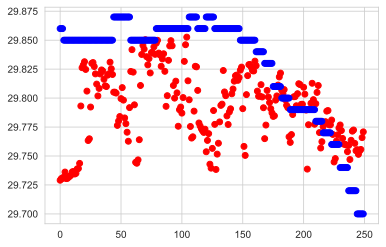

In [26]:
plt.plot(df['estimated_air'].head(250),marker='o',color='red',linestyle='None')
plt.plot(df['at'].head(250),marker='o',color='blue',linestyle='None')
plt.show()

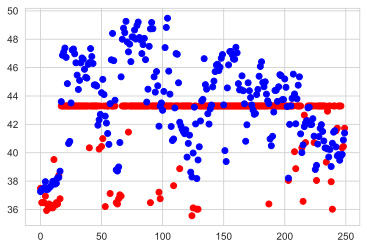

In [27]:
plt.plot(df['estimated_st'].head(250),marker='o',color='red',linestyle='None')
plt.plot(df['st'].head(250),marker='o',color='blue',linestyle='None')
plt.show()

#here this weird red line of estimated st is more visible

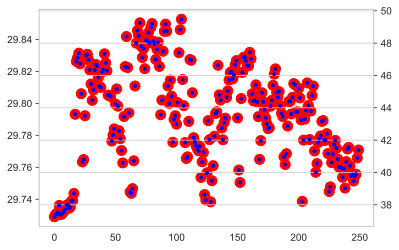

In [28]:
df['estimated_air'].head(250).plot(marker='o',markersize=10,color='red',linestyle='None')
df['st'].head(250).plot(secondary_y=True, marker='.',color='blue',linestyle='None')

#estimated air and surface temperature seem to display exactly the same distribution of values

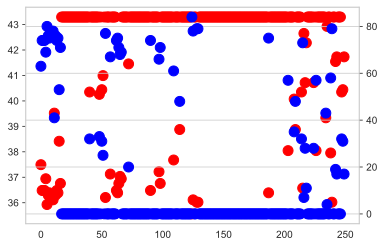

In [43]:
fig, ax =plt.subplots()
df['estimated_st'].head(250).plot(marker='o',markersize=10,color='red',linestyle='None', ax=ax)
df['tc'].head(250).plot(marker='o',markersize=10,color='blue',linestyle='None', ax=ax, secondary_y=True)


#estimated st and tree cover display exactly the same distribution of values, but inverted

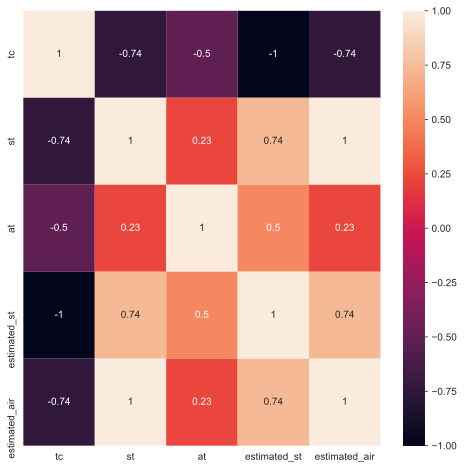

In [29]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
sns.heatmap(((df[['tc','st','at','estimated_st','estimated_air']]).corr()), annot=True)

#correlations:
#estimated_St and tc: -1
#estimated air and st. 1